In [1]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
print('pytorch version:', torch.__version__)
global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', global_device)
from torch.utils.data import DataLoader, random_split, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MultilabelAveragePrecision

pytorch version: 2.2.0.dev20231027+cu121
Device: cuda:0


In [2]:
# Matplotlib settings
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

# Data loading

In [22]:
df_trainval = pd.read_csv('data/train.csv')
df_train, df_val = train_test_split(df_trainval, test_size=0.2, random_state=42)
df_train['tags'] = df_train['tags'].apply(lambda x: np.array(list(map(int, x.split(',')))))
df_val['tags'] = df_val['tags'].apply(lambda x: np.array(list(map(int, x.split(',')))))

df_test = pd.read_csv('data/test.csv')

In [4]:
max_len = 200
global_idx2embeds = {} # {idx: np.ndarray[n, 768])}
for npy_file in tqdm(glob('data/track_embeddings/*')):
    track_idx = int(npy_file.split('\\')[1].split('.')[0])
    embeds = np.load(npy_file)
    global_idx2embeds[track_idx] = embeds[:min(len(embeds)-1, max_len)]

100%|██████████| 76714/76714 [01:50<00:00, 693.91it/s] 


In [5]:
emb_train_mean = 0
for track_idx in tqdm(df_train['track']):
    emb_train_mean += global_idx2embeds[track_idx].mean(axis=0)
emb_train_mean /= len(df_train['track'])
emb_train_mean.shape

100%|██████████| 40907/40907 [00:36<00:00, 1117.00it/s]


(768,)

In [6]:
class TrackDataset(torch.utils.data.Dataset):
    def __init__(self, df_tags, test=False):
        self.df_tags = df_tags
        self.test = test

    def __len__(self):
        return len(self.df_tags)

    def __getitem__(self, idx):
        track_idx = self.df_tags.iloc[idx]['track']
        embeds = global_idx2embeds[track_idx]
        if self.test:
            return track_idx, embeds
        labels_onehot = np.zeros(256)
        labels_onehot[self.df_tags.iloc[idx]['tags']] = 1
        return track_idx, embeds, labels_onehot

In [23]:
def collate(batch):
    track_idxs = torch.IntTensor(np.vstack([triplet[0] for triplet in batch]))
    embeds_list = [torch.FloatTensor(triplet[1] - emb_train_mean).to(global_device) for triplet in batch]
    embeds = pack_sequence(embeds_list, enforce_sorted=False).to(global_device)
    labels_onehot = torch.FloatTensor(np.vstack([triplet[2] for triplet in batch])).to(global_device)
    return track_idxs, embeds, labels_onehot

def collate_test(batch):
    track_idxs = torch.IntTensor(np.vstack([triplet[0] for triplet in batch]))
    embeds_list = [torch.FloatTensor(triplet[1] - emb_train_mean) for triplet in batch]
    embeds = pack_sequence(embeds_list, enforce_sorted=False).to(global_device)
    return track_idxs, embeds

batch_size = 64

dataset_train = TrackDataset(df_train)
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True, collate_fn=collate)

dataset_val = TrackDataset(df_val)
dataloader_val = DataLoader(dataset_val, batch_size, shuffle=False, collate_fn=collate)
dataloader_val_astest = DataLoader(dataset_val, batch_size, shuffle=False, collate_fn=collate_test)

dataset_test = TrackDataset(df_test, test=True)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=False, collate_fn=collate_test)

In [26]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term).unsqueeze(0)
        pe[0, :, 1::2] = torch.cos(position * div_term).unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]  #batch first
        return self.dropout(x)


class TrackToTags(pl.LightningModule):
    def __init__(self, num_classes=256, input_dim=768, hidden_dim=512, dropout=0):
        super().__init__()
        self.num_classes = num_classes
        self.pos_encoder = PositionalEncoding(input_dim, dropout, max_len=max_len)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                input_dim, nhead=4, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True
            ),
            num_layers=3
        )
        # self.avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.bn = nn.LayerNorm(input_dim)
        self.fc = nn.Linear(input_dim, num_classes)

        self.loss = nn.BCEWithLogitsLoss()

        self.metric = average_precision_score
        self._transit_val = {'preds': [], 'labels': []}
        self._transit_train = {'loss': []}
        
    def forward(self, embeds):
        unpacked, lengths = pad_packed_sequence(embeds, batch_first=True)
        x = self.pos_encoder(unpacked)
        pad_mask = torch.BoolTensor(x.shape[:2]).to(global_device)
        for i, l in enumerate(lengths):
            pad_mask[i,:l] = False
            pad_mask[i,l:] = True

        trans_out = self.transformer(x, src_key_padding_mask=pad_mask)
        x = [(v.sum(0)/length).unsqueeze(0) for v, length in zip(trans_out, lengths)]
        x = torch.cat(x, dim = 0)
        x = self.bn(x)
        outs = self.fc(x)
        return outs

    def training_step(self, batch, batch_idx):
        track_idxs, embeds_list, labels_onehot = batch
        pred_logits = self(embeds_list)
        loss = self.loss(pred_logits, labels_onehot)
        self.log("train_loss", loss, prog_bar=True)
        self._transit_train['loss'].append(loss.cpu())
        self.log("lr", self.scheduler.get_last_lr()[-1], prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        track_idxs, embeds_list, labels_onehot = batch
        pred_logits = self(embeds_list)
        loss = self.loss(pred_logits, labels_onehot)
        self.log("val_loss", loss, prog_bar=True)
        
        pred_probs = torch.sigmoid(pred_logits)
        self._transit_val['labels'].append(np.array(labels_onehot.int().cpu()))
        self._transit_val['preds'].append(np.array(pred_probs.cpu()))

    def on_validation_epoch_end(self):
        preds = np.vstack(self._transit_val['preds'])
        labels = np.vstack(self._transit_val['labels'])
        ap = self.metric(labels, preds)
        self.log('val_ap', ap, prog_bar=True)
        epoch_train_loss = np.mean(self._transit_train['loss'])
        self.log('etr_loss', epoch_train_loss, prog_bar=True)
        self._transit_val['labels'] = []
        self._transit_val['preds'] = []
        self._transit_train['loss'] = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.7)
        # warmup_steps = 128
        # def warmup(current_step: int):
        #     if current_step < warmup_steps:
        #         return current_step/warmup_steps
        #     else:
        #         return np.sqrt(warmup_steps/current_step)
        # self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                                "scheduler": self.scheduler,
                                "interval": "epoch",
                                "frequency": 5
                                },
               }

In [27]:
checkpoint_callback = ModelCheckpoint(dirpath='lightning_logs/trans_accum2048_wowarm/',
                                      filename='{epoch}-{etr_loss:.3f}-{val_loss:.3f}-{val_ap:.3f}', 
                                      save_top_k=-1, 
                                      monitor="val_ap", 
                                      every_n_epochs=1)
trainer = pl.Trainer(accelerator="gpu", devices=1, val_check_interval=1.0, 
                     max_epochs=30, log_every_n_steps=100,
                     accumulate_grad_batches=2048//batch_size,
                     callbacks=[checkpoint_callback])
model = TrackToTags(dropout=0.2, hidden_dim=1024)
trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | pos_encoder | PositionalEncoding | 0     
1 | transformer | TransformerEncoder | 11.8 M
2 | bn          | LayerNorm          | 1.5 K 
3 | fc          | Linear             | 196 K 
4 | loss        | BCEWithLogitsLoss  | 0     
---------------------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params
48.075    Total estimated model params size (MB)


Epoch 7:   7%|▋         | 44/640 [00:33<07:38,  1.30it/s, v_num=284, train_loss=0.0701, lr=7e-5, val_loss=0.0682, val_ap=0.0291, etr_loss=0.0688]   

In [117]:
import gc
gc.collect()
torch.cuda.empty_cache()

Epoch 0:   4%|▎         | 23/640 [2:56:42<79:00:36,  0.00it/s, v_num=270, train_loss=0.168, lr=0.000141]


In [104]:
# model = TrackToTags.load_from_checkpoint('lightning_logs/trans_pos/epoch=22-val_loss=0.047-val_ap=0.220.ckpt',
#                                           dropout=0.2, hidden_dim=1024)
checkpoint_callback = ModelCheckpoint(dirpath='lightning_logs/trans_pos/',
                                      filename='{epoch}-{val_loss:.3f}-{val_ap:.3f}', 
                                      save_top_k=-1, 
                                      monitor="val_ap", 
                                      every_n_epochs=1)
trainer = pl.Trainer(accelerator="gpu", devices=1, val_check_interval=1.0, 
                     max_epochs=30, log_every_n_steps=100,
                     callbacks=[checkpoint_callback])
# model = TrackToTags(dropout=0.2, hidden_dim=1024)
trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name        | Type               | Params
---------------------------------------------------
0 | pos_encoder | PositionalEncoding | 0     
1 | transformer | TransformerEncoder | 7.9 M 
2 | bn          | LayerNorm          | 1.5 K 
3 | fc          | Linear             | 196 K 
4 | loss        | BCEWithLogitsLoss  | 0     
---------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.314    Total estimated model params size (MB)


Epoch 0:   3%|▎         | 22/640 [00:12<05:44,  1.80it/s, v_num=266, train_loss=0.0392, lr=0.0002]

In [16]:
checkpoint_callback = ModelCheckpoint(dirpath='lightning_logs/transformer512_2l_4heads_2/',
                                      filename='{epoch}-{val_loss:.3f}-{val_ap:.3f}', 
                                      save_top_k=-1, 
                                      monitor="val_ap", 
                                      every_n_epochs=1)
trainer = pl.Trainer(accelerator="gpu", devices=1, val_check_interval=1.0, 
                     max_epochs=50, log_every_n_steps=100,
                     callbacks=[checkpoint_callback])
trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | bn          | LayerNorm          | 1.0 K 
1 | projector   | Linear             | 393 K 
2 | fc          | Linear             | 131 K 
3 | transformer | TransformerEncoder | 3.2 M 
4 | avg_pooling | AdaptiveAvgPool1d  | 0     
5 | loss        | BCEWithLogitsLoss  | 0     
---------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.728    Total estimated model params size (MB)


Epoch 43:  40%|████      | 32/80 [00:07<00:11,  4.26it/s, v_num=166, train_loss=0.0465, val_loss=0.0576, val_ap=0.0988]

In [12]:
def predict(model, loader):
    model.to(global_device)
    model.eval()
    track_idxs = []
    predictions = []
    with torch.no_grad():
        for data in loader:
            track_idx, embeds = data
            # embeds = [x.to(global_device) for x in embeds]
            pred_logits = model(embeds)
            pred_probs = torch.sigmoid(pred_logits)
            predictions.append(pred_probs.cpu().numpy())
            track_idxs.append(track_idx.numpy())
    predictions = np.vstack(predictions)
    track_idxs = np.vstack(track_idxs).ravel()
    return track_idxs, predictions

In [13]:
val_true = np.array([y[2] for y in dataset_val])
track_idxs_val, val_pred = predict(model, dataloader_val_astest)
average_precision_score(val_true, val_pred)

0.0976463191074462

In [14]:
track_idxs, predictions = predict(model.to(global_device), dataloader_test)

In [15]:
predictions_df = pd.DataFrame([
    {'track': track, 'prediction': ','.join([str(p) for p in probs])}
    for track, probs in zip(track_idxs, predictions)
])
predictions_df.to_csv('results/prediction.csv', index=False)

In [33]:
df = pd.read_csv('lightning_logs/version_25/metrics.csv')

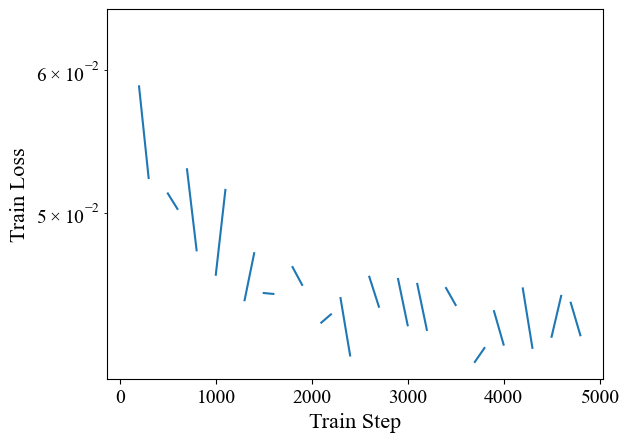

In [34]:
plt.plot(df['step'], df['train_loss'])
plt.xlabel('Train Step')
plt.ylabel('Train Loss')
plt.yscale('log')

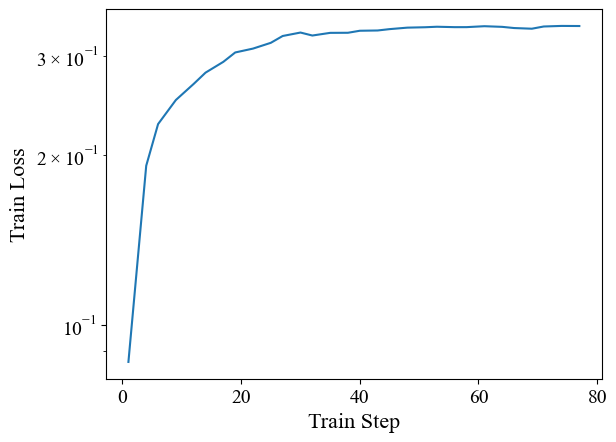

In [44]:
plt.plot(df['val_ap'].dropna())
plt.xlabel('Train Step')
plt.ylabel('Train Loss')
plt.yscale('log')